In [30]:
import numpy as np
import pandas as pd
import os
from pprint import pprint
import matplotlib.pyplot as plt
import lightgbm as lgb
import re
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure

In [83]:
train_df = pd.read_csv('./input/application_train.csv')
test_df = pd.read_csv('./input/application_test.csv')
POS_CASH_balance = pd.read_csv('./input/POS_CASH_balance.csv')
bureau = pd.read_csv('./input/bureau.csv')
bureau_balance = pd.read_csv('./input/bureau_balance.csv')
credit_balance = pd.read_csv('./input/credit_card_balance.csv')
installments_payment = pd.read_csv('./input/installments_payments.csv')
previous_application = pd.read_csv('./input/previous_application.csv')

In [17]:
train_df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [3]:
# process application_train.csv
for col in train_df:
    if (train_df[col].dtype != 'int64' or train_df[col].nunique() > 2) and train_df[col].dtype != 'float64':
        # features (string) with 2 categories
        if train_df[col].nunique() == 2 and col != 'EMERGENCYSTATE_MODE':
            train_df[col][train_df[col] == train_df[col].unique()[0]] = 0
            train_df[col][train_df[col] == train_df[col].unique()[1]] = 1
            train_df[col] = train_df[col].astype('int64')
            continue
        # features (string) with 2 categories + nan
        if col == 'EMERGENCYSTATE_MODE':
            train_df['EMERGENCYSTATE_MODE'] = train_df['EMERGENCYSTATE_MODE'].fillna('nan')
            temp_cols = pd.get_dummies(train_df.EMERGENCYSTATE_MODE, prefix='EMERGENCYSTATE_MODE').astype('int64')
            train_df = pd.concat([train_df, temp_cols], axis=1)
            train_df.drop('EMERGENCYSTATE_MODE', axis=1, inplace=True)
            continue
        if train_df[col].nunique() > 2 and train_df[col].nunique() < 60:
            train_df[col] = train_df[col].fillna('nan')
            #print(train_df[col].nunique(), train_df[col].unique(), col)
            temp_cols = pd.get_dummies(train_df[col], prefix=col).astype('int64')
            train_df = pd.concat([train_df, temp_cols], axis=1)
            train_df.drop(col, axis=1, inplace=True)
            continue
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].fillna('nan')
        temp_cols = pd.get_dummies(train_df[col], prefix=col).astype('int64')
        train_df = pd.concat([train_df, temp_cols], axis=1)
        train_df.drop(col, axis=1, inplace=True)

# fill in the nan with median of the column for numerical data
for col in train_df.columns[train_df.isna().any()].tolist():
    np_array = train_df[col].to_numpy()
    train_df[col] = train_df[col].fillna(np.median(np_array[~np.isnan(np_array)]))

<ipython-input-3-e4ce150824d6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col][train_df[col] == train_df[col].unique()[0]] = 0
<ipython-input-3-e4ce150824d6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col][train_df[col] == train_df[col].unique()[1]] = 1


In [4]:
train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # drop the Punctuation
x = pd.concat([train_df.iloc[:,0], train_df.iloc[:,2:]],axis=1)
y = train_df.iloc[:,1]

In [ ]:
'''params = {
    'boosting_type': 'gbdt',
    'force_col_wise': True,
    'objective': 'binary',
    'learning_rate': 0.1, 
    'num_leaves': 50, 
    'max_depth': 6,
    'subsample': 0.8, 
    'colsample_bytree': 0.8}

data_train = lgb.Dataset(x, y, silent=True)
cv_results = lgb.cv(params, data_train, num_boost_round=1000, nfold=10, stratified=False, shuffle=True, metrics='auc',
                    early_stopping_rounds=50, verbose_eval=1, show_stdv=True, seed=0)'''

In [9]:
# grid search for max_depth and num_leaves
model_lgb = lgb.LGBMClassifier(objective='binary',num_leaves=50,
                              learning_rate=0.1, n_estimators=43, max_depth=6,
                              metric='auc', bagging_fraction = 0.8,feature_fraction = 0.8)

params={
    'max_depth': [6, 8, 10, 12, 14],
    'num_leaves': [65, 70, 75, 80],
}

gsearch = GridSearchCV(estimator=model_lgb, param_grid=params, scoring='roc_auc', cv=10, verbose=1, n_jobs=10)
gsearch.fit(x, y)
print('Best params:', gsearch.best_params_, 'Best AUC:', gsearch.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/home/samyuen/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   37.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:  4.3min finished


GridSearchCV(cv=10,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      feature_fraction=0.8, max_depth=6,
                                      metric='auc', n_estimators=43,
                                      num_leaves=50, objective='binary'),
             n_jobs=10,
             param_grid={'max_depth': [6, 8, 10, 12, 14],
                         'num_leaves': [65, 70, 75, 80]},
             scoring='roc_auc', verbose=1)

Best params: {'max_depth': 10, 'num_leaves': 75} Best AUC: 0.7526776959751345


In [13]:
# grid search for min_child_samples and min_child_weight to prevent overfitting
model_lgb = lgb.LGBMClassifier(objective='binary',num_leaves=75,
                              learning_rate=0.1, n_estimators=43, max_depth=10,
                              metric='auc', bagging_fraction = 0.8,feature_fraction = 0.8)

params={
    'min_child_samples': [12, 13, 14, 15, 16, 17, 18],
    'min_child_weight': [0.0001, 0.0005, 0.001, 0.002],
}

gsearch = GridSearchCV(estimator=model_lgb, param_grid=params, scoring='roc_auc', cv=10, verbose=1, n_jobs=10)
gsearch.fit(x, y)
print('Best params:', gsearch.best_params_, 'Best AUC:', gsearch.best_score_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   43.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done 280 out of 280 | elapsed:  6.2min finished


Best params: {'min_child_samples': 15, 'min_child_weight': 0.0001} Best AUC: 0.7529278910264952


In [15]:
# grid search for bagging_fraction and feature_fraction to prevent overfitting
model_lgb = lgb.LGBMClassifier(objective='binary',num_leaves=75,
                              learning_rate=0.1, n_estimators=43, max_depth=10,
                              metric='auc', bagging_freq = 5,  min_child_samples=15, min_child_weight=0.0001)

params={
    'feature_fraction': [0.62, 0.65, 0.68, 0.7, 0.72, 0.75, 0.78]
    #'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0]
}

gsearch = GridSearchCV(estimator=model_lgb, param_grid=params, scoring='roc_auc', cv=10, verbose=1, n_jobs=10)
gsearch.fit(x, y)
print('Best params:', gsearch.best_params_, 'Best AUC:', gsearch.best_score_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   45.1s
[Parallel(n_jobs=10)]: Done  70 out of  70 | elapsed:  1.5min finished


Best params: {'feature_fraction': 0.78} Best AUC: 0.7527754169073801


In [16]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'binary', 
    'learning_rate': 0.005, 
    'num_leaves': 75, 
    'max_depth': 10,
    'min_data_in_leaf': 15,
    'min_child_weight': 0.0001,
    'subsample': 1, 
    'colsample_bytree': 0.78, 
    }

data_train = lgb.Dataset(x, y, silent=True)
cv_results = lgb.cv(params, data_train, num_boost_round=10000, nfold=10, stratified=False, shuffle=True, metrics='auc',
                    early_stopping_rounds=50, verbose_eval=100, show_stdv=True)

/home/samyuen/.local/lib/python3.8/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/samyuen/.local/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 22380, number of negative: 254379
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11714
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 273
[LightGBM] [Info] Number of positive: 22416, number of negative: 254343
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11714
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 273
[LightGBM] [Info] Number of positive: 22339, number of negative: 254420
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048372 seconds.
You can set `force_row_

/home/samyuen/.local/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	cv_agg's auc: 0.73762 + 0.0042639
[200]	cv_agg's auc: 0.740635 + 0.00398198
[300]	cv_agg's auc: 0.743547 + 0.00371763
[400]	cv_agg's auc: 0.74631 + 0.00368916
[500]	cv_agg's auc: 0.748634 + 0.00375566
[600]	cv_agg's auc: 0.750554 + 0.00373822
[700]	cv_agg's auc: 0.752371 + 0.0036722
[800]	cv_agg's auc: 0.753764 + 0.0036432
[900]	cv_agg's auc: 0.754909 + 0.00359447
[1000]	cv_agg's auc: 0.755867 + 0.00364268
[1100]	cv_agg's auc: 0.756619 + 0.0037013
[1200]	cv_agg's auc: 0.757246 + 0.00372217
[1300]	cv_agg's auc: 0.757787 + 0.00375822
[1400]	cv_agg's auc: 0.758219 + 0.00377669
[1500]	cv_agg's auc: 0.758575 + 0.00386818
[1600]	cv_agg's auc: 0.758861 + 0.00394098
[1700]	cv_agg's auc: 0.7591 + 0.0040154
[1800]	cv_agg's auc: 0.75931 + 0.00402865
[1900]	cv_agg's auc: 0.759481 + 0.0040603
[2000]	cv_agg's auc: 0.759613 + 0.00404738
[2100]	cv_agg's auc: 0.759722 + 0.00405459
[2200]	cv_agg's auc: 0.759802 + 0.00410108
[2300]	cv_agg's auc: 0.759847 + 0.0041297
[2400]	cv_agg's auc: 0.759926 + 

In [17]:
print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', cv_results['auc-mean'][-1])

best n_estimators: 2760
best cv score: 0.7600279949443478


In [73]:
# use the hyparameters tune by above
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1)
model = lgb.LGBMClassifier(objective='binary', learning_rate=0.005, num_leaves=75, max_depth=10, n_estimators=2760,
                           min_data_in_leaf=15, min_child_weight=0.0001, subsample=1, colsample_bytree=0.78, 
                           num_boost_round=10000, stratified=False, shuffle=True, metrics='auc',
                           early_stopping_rounds=50, verbose_eval=100, show_stdv=True)
model.fit(X=X_train, y=y_train, eval_set = (X_valid, y_valid))

/home/samyuen/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's auc: 0.712257
[2]	valid_0's auc: 0.714714
[3]	valid_0's auc: 0.716202
[4]	valid_0's auc: 0.725457
[5]	valid_0's auc: 0.727609
[6]	valid_0's auc: 0.727865
[7]	valid_0's auc: 0.727469
[8]	valid_0's auc: 0.72696
[9]	valid_0's auc: 0.727673
[10]	valid_0's auc: 0.727705
[11]	valid_0's auc: 0.72772
[12]	valid_0's auc: 0.727772
[13]	valid_0's auc: 0.727587
[14]	valid_0's auc: 0.727488
[15]	valid_0's auc: 0.727253
[16]	valid_0's auc: 0.727079
[17]	valid_0's auc: 0.726974
[18]	valid_0's auc: 0.72893
[19]	valid_0's auc: 0.728621
[20]	valid_0's auc: 0.72878
[21]	valid_0's auc: 0.729615
[22]	valid_0's auc: 0.729766
[23]	valid_0's auc: 0.729779
[24]	valid_0's auc: 0.729623
[25]	valid_0's auc: 0.730154
[26]	valid_0's auc: 0.729963
[27]	valid_0's auc: 0.729844
[28]	valid_0's auc: 0.730258
[29]	valid_0's auc: 0.730134
[30]	valid_0's auc: 0.72999
[31]	valid_0's auc: 0.73008
[32]	valid_0's auc: 0.730399
[33]	valid_0's auc: 0.730454
[34]	valid_0's auc: 0.730435
[35]	valid_0's auc: 0.730295


LGBMClassifier(colsample_bytree=0.78, early_stopping_rounds=50,
               learning_rate=0.005, max_depth=10, metrics='auc',
               min_child_weight=0.0001, min_data_in_leaf=15, n_estimators=2760,
               num_boost_round=10000, num_leaves=75, objective='binary',
               show_stdv=True, shuffle=True, stratified=False, subsample=1,
               verbose_eval=100)

### Feature engineering/selection

In [74]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x.columns)), columns=['Value','Feature'])

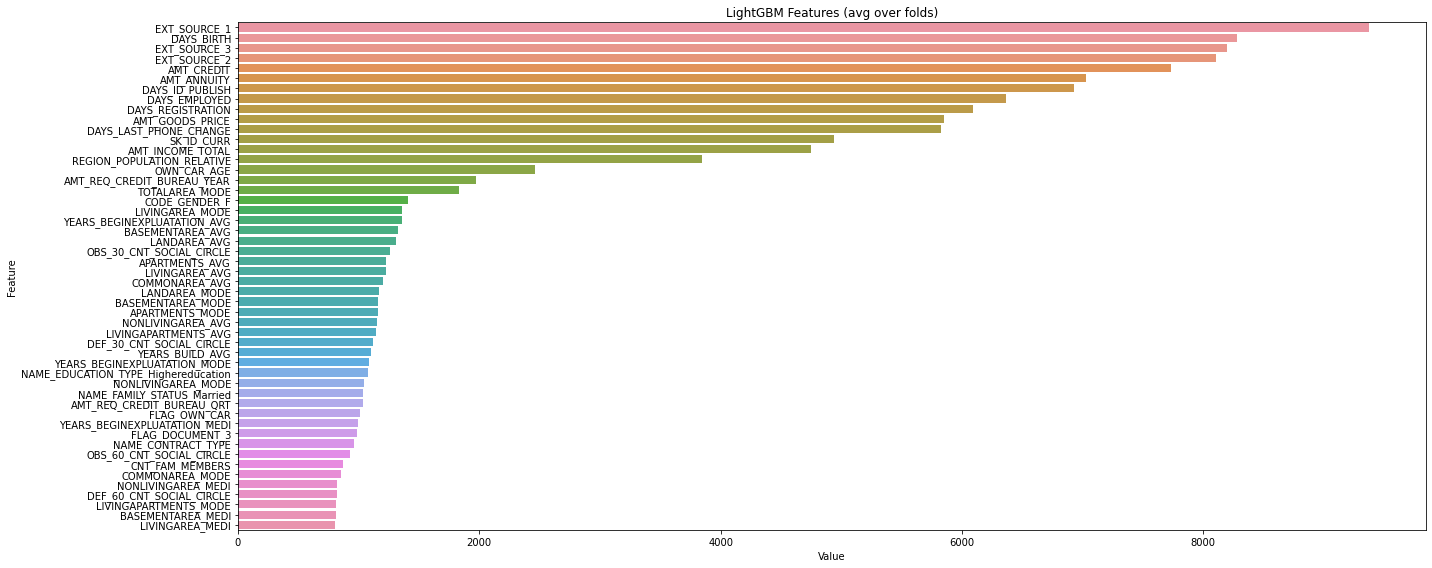

In [75]:
plt.figure(figsize=(20, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50,:])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [80]:
importance_median = np.median(feature_imp['Value'].to_numpy())
important_features = feature_imp[feature_imp['Value']>=importance_median]
important_x = train_df[important_features['Feature']]

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(important_x, y, test_size=0.1)
model = lgb.LGBMClassifier(objective='binary', learning_rate=0.005, num_leaves=75, max_depth=10, n_estimators=2760,
                           min_data_in_leaf=15, min_child_weight=0.0001, subsample=1, colsample_bytree=0.78, 
                           num_boost_round=10000, stratified=False, shuffle=True, metrics='auc',
                           early_stopping_rounds=50, verbose_eval=100, show_stdv=True)
model.fit(X=X_train, y=y_train, eval_set = (X_valid, y_valid))

[1]	valid_0's auc: 0.71799
[2]	valid_0's auc: 0.719452
[3]	valid_0's auc: 0.720152
[4]	valid_0's auc: 0.726093
[5]	valid_0's auc: 0.725797
[6]	valid_0's auc: 0.730757
[7]	valid_0's auc: 0.73218
[8]	valid_0's auc: 0.733149
[9]	valid_0's auc: 0.733082
[10]	valid_0's auc: 0.734611
[11]	valid_0's auc: 0.734301
[12]	valid_0's auc: 0.735153
[13]	valid_0's auc: 0.735148
[14]	valid_0's auc: 0.735442
[15]	valid_0's auc: 0.737579
[16]	valid_0's auc: 0.737682
[17]	valid_0's auc: 0.737822
[18]	valid_0's auc: 0.737404
[19]	valid_0's auc: 0.73801
[20]	valid_0's auc: 0.737673
[21]	valid_0's auc: 0.73775
[22]	valid_0's auc: 0.737469
[23]	valid_0's auc: 0.73717
[24]	valid_0's auc: 0.73723
[25]	valid_0's auc: 0.737003
[26]	valid_0's auc: 0.736688
[27]	valid_0's auc: 0.736385
[28]	valid_0's auc: 0.736239
[29]	valid_0's auc: 0.736168
[30]	valid_0's auc: 0.736585
[31]	valid_0's auc: 0.736995
[32]	valid_0's auc: 0.736758
[33]	valid_0's auc: 0.737381
[34]	valid_0's auc: 0.737334
[35]	valid_0's auc: 0.73719
[

LGBMClassifier(colsample_bytree=0.78, early_stopping_rounds=50,
               learning_rate=0.005, max_depth=10, metrics='auc',
               min_child_weight=0.0001, min_data_in_leaf=15, n_estimators=2760,
               num_boost_round=10000, num_leaves=75, objective='binary',
               show_stdv=True, shuffle=True, stratified=False, subsample=1,
               verbose_eval=100)